In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import pandas as pd
import tensorflow as tf

In [2]:
from nnAudio import Spectrogram

import os
os.environ['CUDA_VISIBLE_DEVICES']='3'
device = "cuda:0"

In [3]:
import nvidia.dali as dali

In [4]:
y_list = np.load('./y_list.npy')
# y_torch = torch.tensor(y_list, device=device).float()

# STFT

In [5]:
spec_layer = Spectrogram.STFT(device=device)
timing = []
for e in range(1):
    t_start = time.time()
    spec = spec_layer(y_torch)
    time_used = time.time()-t_start
#     print(time_used)
    timing.append(time_used)
    
print("mean = ",np.mean(timing))
print("std = ", np.std(timing))

STFT kernels created, time used = 0.2520 seconds
mean =  0.015856266021728516
std =  0.0


In [6]:
spec.shape

torch.Size([1770, 1025, 157])

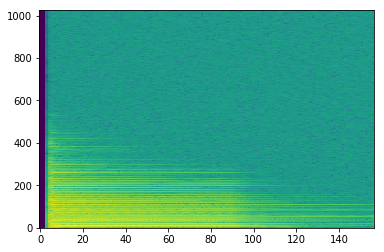

In [7]:
plt.imshow(torch.log(spec[0]+1e-5).cpu().numpy(), aspect='auto', origin='lower')

# DALI

In [5]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import nvidia.dali as dali
import librosa

class SpectrogramPipeline(Pipeline):
    def __init__(self, device, batch_size, nfft, window_length, window_step, num_threads=1, device_id=0):
        super(SpectrogramPipeline, self).__init__(batch_size, num_threads, device_id)
        self.device = device

        self.external_source = ops.ExternalSource()
        self.spectrogram = ops.Spectrogram(device=self.device,
                                           nfft=nfft,
                                           window_length=window_length,
                                           window_step=window_step,
                                           power=1)

    def define_graph(self):
        self.data = self.external_source()
        out = self.data.gpu() if self.device == 'gpu' else self.data
        out = self.spectrogram(out)
        return out

    def iter_setup(self):
        self.feed_input(self.data, y_list.astype(np.float32))

In [11]:
n_fft = 2048
hop_length = 512
pipe = SpectrogramPipeline(device='gpu', batch_size=1770, nfft=n_fft, window_length=n_fft, window_step=hop_length)
pipe.build()

In [12]:
timing = []
for e in range(20):
    t_start = time.time()
    outputs = pipe.run()
    spectrogram_dali = outputs[0].as_cpu().at(0)
    time_used = time.time()-t_start
    print(time_used)
    timing.append(time_used)
    
print("mean = ",np.mean(timing))
print("std = ", np.std(timing))

8.333369731903076
3.8594253063201904
1.1218314170837402
1.1213445663452148
1.1218197345733643
1.1246614456176758
1.122107744216919
1.1238787174224854
1.1248681545257568
1.1236367225646973
1.124664306640625
1.124770164489746
1.1255860328674316
1.1247570514678955
1.1223235130310059
1.1208627223968506
1.1238160133361816
1.1224169731140137
1.1244113445281982
1.1232776641845703
mean =  1.620691466331482
std =  1.6511141195623047


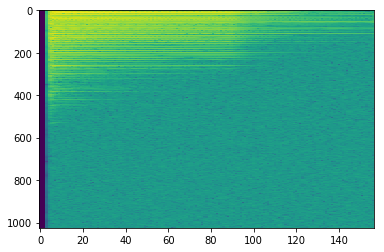

In [11]:
plt.imshow(np.log(outputs[0].as_cpu().at(0)+1e-5), aspect='auto')

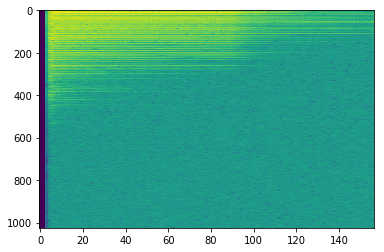

In [12]:
plt.imshow(np.log(spec[0].cpu()+1e-5), aspect='auto')

In [5]:
timing = []
input = tf.placeholder(tf.float32, shape=(None,80000))
stft = tf.signal.stft(input, 2048, 512, pad_end=False)
output_m = tf.abs(stft) 
with tf.Session() as sess:
    for e in range(20):
        t_start = time.time()
        sess.run(output_m, feed_dict={input:y_list})
#         sess.run(output_m, feed_dict={input:y_list[1000:]})    
        time_used = time.time()-t_start
#         print(time_used)
        timing.append(time_used)
    
print("mean = ",np.mean(timing))
print("std = ", np.std(timing))

mean =  1.4418811798095703
std =  1.5161438212276783


In [5]:
data = pd.DataFrame(timing,columns=['t_avg'])
data['Type'] = 'tensorflow_GPU'
data.to_csv('./result/Spec_tensorflow_GPU')

# Melspectrogram

In [4]:
mel_filterbank = tf.signal.linear_to_mel_weight_matrix(128,1025)
input = tf.placeholder(tf.float32, shape=(None,80000))
stft = tf.signal.stft(input, 2048, 512, pad_end=False)
output_m = tf.abs(stft) 
mel_spec = tf.tensordot(tf.square(output_m),mel_filterbank, 1)

In [5]:
timing = []
with tf.Session() as sess:
    for e in range(20):
        t_start = time.time()
        sess.run(mel_spec, feed_dict={input:y_list})
#         sess.run(mel_spec, feed_dict={input:y_list[1000:]})
        time_used = time.time()-t_start
#         print(time_used)
        timing.append(time_used)
    
print("mean = ",np.mean(timing))
print("std = ", np.std(timing))

mean =  1.4110182404518128
std =  1.7052302203014043


In [6]:
data = pd.DataFrame(timing,columns=['t_avg'])
data['Type'] = 'tensorflow_GPU'
data.to_csv('./result/Mel_tensorflow_GPU')

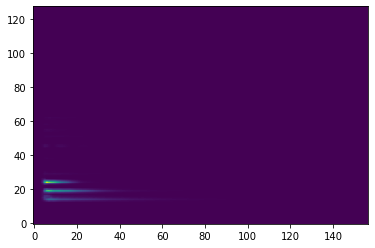

In [10]:
plt.imshow(spec[0].cpu().numpy(), aspect='auto', origin='lower')

# CQT 1992v2

In [4]:
spec_layer = Spectrogram.CQT1992v2(sr=44100, n_bins=84*2, bins_per_octave=24, fmin=55, device=device)
timing = []
for e in range(20):
    t_start = time.time()
    spec = spec_layer(y_torch[:1000])
    spec = spec_layer(y_torch[1000:])
    time_used = time.time()-t_start
#     print(time_used)
    timing.append(time_used)
    
print("mean = ",np.mean(timing))
print("std = ", np.std(timing))

CQT kernels created, time used = 0.1107 seconds
mean =  0.03167051076889038
std =  0.1311743668227233


In [9]:
data = pd.DataFrame(timing,columns=['t_avg'])
data['Type'] = 'torch_GPU'
data.to_csv('./result/CQT1992_torch_GPU')

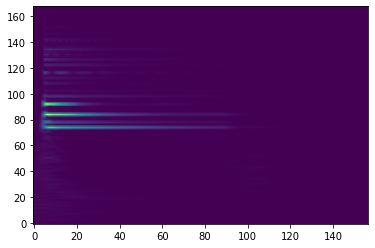

In [6]:
plt.imshow(spec[0].cpu().numpy(), aspect='auto', origin='lower')

# CQT 2010v2

In [14]:
spec_layer = Spectrogram.CQT2010v2(sr=44100, n_bins=84*2, bins_per_octave=24, fmin=55, device=device)
timing = []
for e in range(20):
    t_start = time.time()
    spec = spec_layer(y_torch[:1000])
    spec = spec_layer(y_torch[1000:])
    time_used = time.time()-t_start
#     print(time_used)
    timing.append(time_used)
    
print("mean = ",np.mean(timing))
print("std = ", np.std(timing))

Low pass filter created, time used = 0.0150 seconds
num_octave =  7
No early downsampling is required, downsample_factor =  1
Early downsampling filter created, time used = 0.0000 seconds
CQT kernels created, time used = 0.0090 seconds
mean =  0.445145857334137
std =  0.3949693780231463


In [8]:
data = pd.DataFrame(timing,columns=['t_avg'])
data['Type'] = 'torch_GPU'
data.to_csv('./result/CQT2010_torch_GPU')

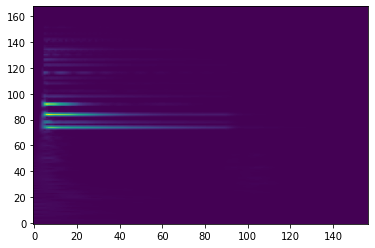

In [16]:
plt.imshow(spec[0].cpu().numpy(), aspect='auto', origin='lower')